In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy import interpolate
import pandas as pd
import sncosmo
import emcee
from multiprocessing import Pool
import corner
import glob
import quadpy
from scipy.optimize import minimize
from IPython.display import display, Math
import getdist
from getdist import plots, MCSamples

gk = quadpy.c1.gauss_kronrod(40)

In [2]:
class cosmo:
    def __init__(self, data):
        self.data = data
    
    def salt2_model(self,theta):
        Om, M, alpha, beta, sigma=theta

        h_inv=lambda x: 1./np.sqrt(Om*(1+x)**3.+(1-Om))
        integral=gk.integrate(h_inv,[np.array([0.]*len(self.data["z"])),np.array(self.data["z"])])
        
        model=5*np.log10((1+self.data["z"])*integral)+M
        mu=self.data["mB"]+self.data["x1"]*alpha-self.data["c"]*beta
    
        sigmaz=0.0012*(5/np.log(10.))*(1.+self.data["z"])/(self.data["z"]*(1.+self.data["z"]/2.))
        
        cov=2.*alpha*self.data["cov_mB_x1"]-2.*beta*self.data["cov_mB_c"]-2.*alpha*beta*self.data["cov_x1_c"]
        sigmalens=0.055*self.data["z"]
        sigma2=sigma**2.+sigmaz**2.+self.data["mBerr"]**2+alpha**2.*self.data["x1err"]**2+beta**2.*self.data["cerr"]**2.+cov+sigmalens**2.
        lnlike=-0.5*np.sum((mu-model)**2./sigma2 + np.log(2*np.pi*sigma2))
        
        if not np.isfinite(lnlike):
            return -np.inf
        return lnlike
    
    def salt2_model_w_bias_cor(self,theta):
        Om, M, alpha, beta, sigma=theta

        h_inv=lambda x: 1./np.sqrt(Om*(1+x)**3.+(1-Om))
        integral=gk.integrate(h_inv,[np.array([0.]*len(self.data["z"])),np.array(self.data["z"])])
                
        model=5*np.log10((1+self.data["z"])*integral)+M
        mu=self.data["mB"]+self.data["x1"]*alpha-self.data["c"]*beta
    
        sigmaz=0.0012*(5/np.log(10.))*(1.+self.data["z"])/(self.data["z"]*(1.+self.data["z"]/2.))

        biascor=self.data["biasCor_mB"]-beta*self.data["biasCor_c"]+alpha*self.data["biasCor_x1"]
        cov=2.*alpha*self.data["cov_mB_x1"]-2.*beta*self.data["cov_mB_c"]-2.*alpha*beta*self.data["cov_x1_c"]
        sigmalens=0.055*self.data["z"]
        sigma2=sigma**2.+sigmaz**2.+self.data["mBerr"]**2+alpha**2.*self.data["x1err"]**2+beta**2.*self.data["cerr"]**2.+cov+sigmalens**2.
        lnlike=-0.5*np.sum((mu-model-biascor)**2./sigma2 + np.log(2*np.pi*sigma2))

        if not np.isfinite(lnlike):
            return -np.inf
        return lnlike
    
    def salt2_model_w_gamma(self,theta):
        Om, M, alpha, beta, gamma, sigma=theta

        h_inv=lambda x: 1./np.sqrt(Om*(1+x)**3.+(1-Om))
        integral=gk.integrate(h_inv,[np.array([0.]*len(self.data["z"])),np.array(self.data["z"])])

        model=5*np.log10((1+self.data["z"])*integral)+M
        mu=self.data["mB"]-2.5*np.log10(1.-self.data["x1"]*alpha+self.data["c"]*beta-gamma*self.data["x1"]*self.data["c"])
    
        sigmaz=0.0012*(5/np.log(10.))*(1.+self.data["z"])/(self.data["z"]*(1.+self.data["z"]/2.))

        fator=-2.5*np.log10(np.e)/(1.-self.data["x1"]*alpha+self.data["c"]*beta-gamma*self.data["x1"]*self.data["c"])
        cov=2.*(-alpha-gamma*self.data["c"])*self.data["cov_mB_x1"]*fator+2.*(beta-gamma*self.data["x1"])*self.data["cov_mB_c"]*fator+2.*(-alpha-gamma*self.data["c"])*(beta-gamma*self.data["x1"])*self.data["cov_x1_c"]*fator**2.
        sigmalens=0.055*self.data["z"]        
        sigma2=sigma**2.+sigmaz**2.+self.data["mBerr"]**2+((-alpha-gamma*self.data["c"])**2.*self.data["x1err"]**2+(beta-gamma*self.data["x1"])**2.*self.data["cerr"]**2.)*fator**2.+cov+sigmalens**2.
        lnlike=-0.5*np.sum((mu-model)**2./sigma2 + np.log(2*np.pi*sigma2))

        if not np.isfinite(lnlike):
            return -np.inf
        return lnlike
    
    def salt2_model_w_new_par(self,theta):
        Om, M, alpha, beta, gamma, delta, tau, sigma=theta

        h_inv=lambda x: 1./np.sqrt(Om*(1+x)**3.+(1-Om))
        integral=gk.integrate(h_inv,[np.array([0.]*len(self.data["z"])),np.array(self.data["z"])])

        model=5*np.log10((1+self.data["z"])*integral)+M
        mu=self.data["mB"]-2.5*np.log10(1.-self.data["x1"]*alpha+self.data["c"]*beta-gamma*self.data["x1"]*self.data["c"]+delta*self.data["c"]**2-tau*self.data["x1"]*self.data["c"]**2)
    
        sigmaz=0.0012*(5/np.log(10.))*(1.+self.data["z"])/(self.data["z"]*(1.+self.data["z"]/2.))

        fator=-2.5*np.log10(np.e)/(1.-self.data["x1"]*alpha+self.data["c"]*beta-gamma*self.data["x1"]*self.data["c"]+delta*self.data["c"]**2-tau*self.data["x1"]*self.data["c"]**2)
        cov=2.*(-alpha-gamma*self.data["c"]-tau*self.data["c"]**2)*self.data["cov_mB_x1"]*fator+2.*(beta-gamma*self.data["x1"]+2*delta*self.data["c"])*self.data["cov_mB_c"]*fator+2.*(-alpha-gamma*self.data["c"]-tau*self.data["c"]**2)*(beta-gamma*self.data["x1"]+2*delta*self.data["c"])*self.data["cov_x1_c"]*fator**2.
        sigmalens=0.055*self.data["z"]        
        sigma2=sigma**2.+sigmaz**2.+self.data["mBerr"]**2+((-alpha-gamma*self.data["c"]-tau*self.data["c"]**2)**2.*self.data["x1err"]**2+(beta-gamma*self.data["x1"]+2*delta*self.data["c"])**2.*self.data["cerr"]**2.)*fator**2.+cov+sigmalens**2.
        lnlike=-0.5*np.sum((mu-model)**2./sigma2 + np.log(2*np.pi*sigma2))

        if not np.isfinite(lnlike):
            return -np.inf
        return lnlike
    
    def log_prior(self, theta):
        Om, M, alpha, beta, sigma=theta     

        if not (0. < Om < 1. and 5. < M < 30. and -5. < alpha < 5. and -5. < beta < 5. and 0. < sigma < 1.):
            return -np.inf
        return 0.

    def log_prior_salt2_w_gamma(self, theta):
        Om, M, alpha, beta, gamma, sigma=theta     

        if not (0. < Om < 1. and 5. < M < 30. and -5. < alpha < 5. and -5. < beta < 5. and -5. < gamma <5. and 0. < sigma < 1.):
            return -np.inf
        return 0.   
    
    def log_prior_salt2_w_new_par(self, theta):
        Om, M, alpha, beta, gamma, delta, tau, sigma=theta

        if not (0. < Om < 1. and 5. < M < 30. and -5. < alpha < 5. and -5. < beta < 5. and -5. < gamma <5. and -1. < delta <10. and -5. < tau <5. and 0. < sigma < 1.):
            return -np.inf
        return 0.   

    def log_probability_salt2_w_gamma(self,theta):
        lp = self.log_prior_salt2_w_gamma(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.salt2_model_w_gamma(theta)
    
    def log_probability_salt2_w_new_par(self,theta):
        lp = self.log_prior_salt2_w_new_par(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.salt2_model_w_new_par(theta)

    def log_probability_salt2(self,theta):
        lp = self.log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.salt2_model(theta)
    
    def log_probability_salt2_w_bias_cor(self,theta):
        lp = self.log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.salt2_model_w_bias_cor(theta)

## Carregando dados

In [3]:
pant=pd.read_csv("pantheon_original_fit.txt",sep="\s+")

In [4]:
cov_mB_x1=-2.5*np.log10(np.e)/pant["x0"]*pant["COV_x1_x0"]
cov_mB_c=-2.5*np.log10(np.e)/pant["x0"]*pant["COV_c_x0"]

In [5]:
data=pant[["zCMB","zCMBERR","mB","mBERR","x1","x1ERR","c","cERR","COV_x1_c","biasCor_mB","biasCor_x1","biasCor_c"]]

In [6]:
data.insert(9, "cov_mB_x1",cov_mB_x1, True)
data.insert(10, "cov_mB_c",cov_mB_c, True)

In [7]:
data.columns=["z","zerr","mB","mBerr","x1","x1err","c","cerr","cov_x1_c","cov_mB_x1","cov_mB_c","biasCor_mB","biasCor_x1","biasCor_c"]

In [8]:
cosmo_salt2=cosmo(data)

## Ajuste SALT2

In [9]:
cosmo_salt2.log_probability_salt2([0.3,24.,0.15,3.5,0.1])

-244.3539807260658

In [10]:
pos = np.array([0.3,24.,0.1,3.5,0.1])+0.01 *np.random.randn(100, 5)
nwalkers, ndim = pos.shape

In [11]:
with Pool() as pool:
    sampler_salt2 = emcee.EnsembleSampler(nwalkers, ndim, cosmo_salt2.log_probability_salt2, pool=pool)
    sampler_salt2.run_mcmc(pos, 2000, progress=True)

  0%|                                          | 5/2000 [00:00<03:12, 10.39it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
  1%|▎                                        | 15/2000 [00:01<03:07, 10.58it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
  1%|▍                                        | 23/2000 [00:02<03:04, 10.70it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs

#### Chains SALT2

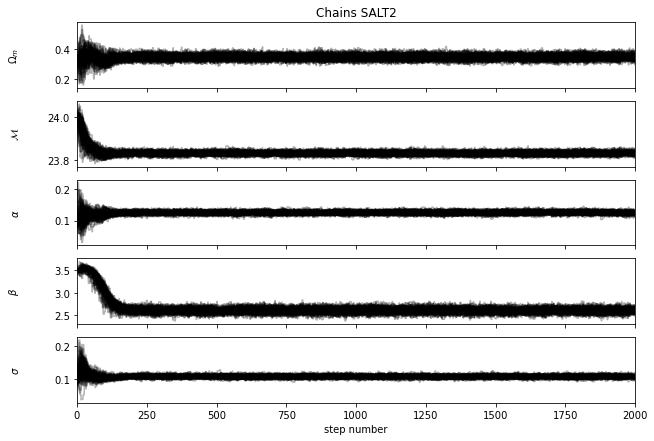

In [12]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples_salt2 = sampler_salt2.get_chain()
labels = [r"$\Omega_m$",r"$\mathcal{M}$",r"$\alpha$",r"$\beta$",r"$\sigma$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_salt2[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_salt2))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    if i==0:
        ax.set_title("Chains SALT2")

    
axes[-1].set_xlabel("step number");

In [13]:
flat_samples_salt2 = sampler_salt2.get_chain(discard=1000, thin=15, flat=True) # oq esse thin significa?

In [14]:
labels_gdist = [r"\Omega_m",r"\mathcal{M}",r"\alpha",r"\beta",r"\sigma"]
names_gdist = ["Om","M","a","b","sig"]
samples_salt2 = MCSamples(samples=flat_samples_salt2, names=names_gdist, labels=labels_gdist)

Removed no burn in


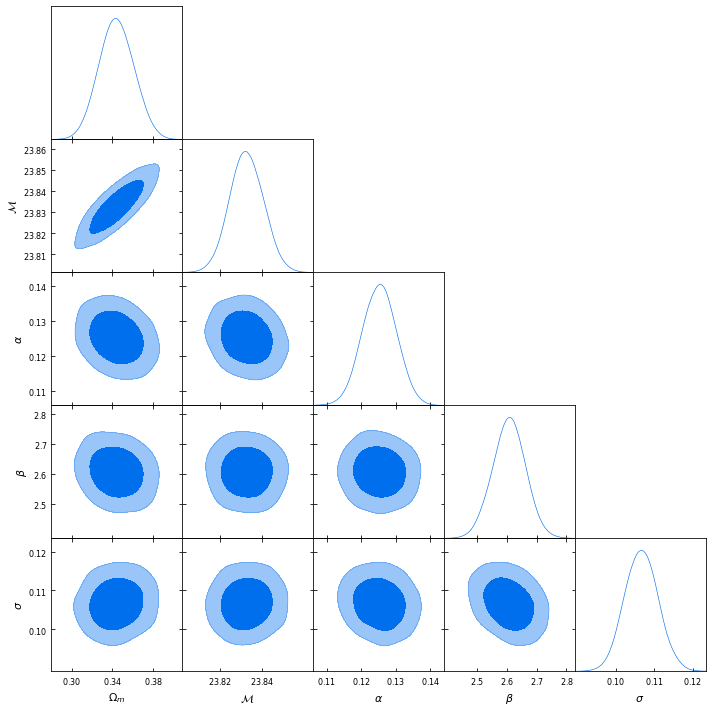

In [15]:
g = plots.get_subplot_plotter()
samples_salt2.updateSettings({'contours': [0.68, 0.95]})
g.settings.num_plot_contours = 2
g.triangle_plot(samples_salt2, filled=True)

## Ajuste SALT2 com correção de bias

In [16]:
cosmo_salt2.log_probability_salt2_w_bias_cor([0.3,24.,0.15,3.5,0.1])

-108.43017649896528

In [17]:
pos = np.array([0.3,24.,0.1,3.5,0.1])+0.01 *np.random.randn(100, 5)
nwalkers, ndim = pos.shape

In [18]:
with Pool() as pool:
    sampler_salt2_bias_cor = emcee.EnsembleSampler(nwalkers, ndim, cosmo_salt2.log_probability_salt2_w_bias_cor, pool=pool)
    sampler_salt2_bias_cor.run_mcmc(pos, 2000, progress=True)

  0%|                                          | 3/2000 [00:00<03:29,  9.53it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
  0%|                                          | 5/2000 [00:00<03:26,  9.64it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
  0%|▏                                        | 10/2000 [00:01<03:23,  9.77it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
  1%|▎                                        | 13/2000 [00:01<03:24,  9.73it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWar

#### Chains SALT2 com correção de bias

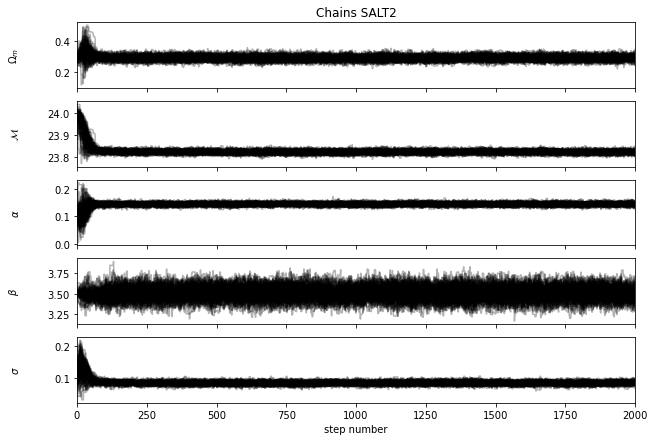

In [19]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples_salt2_bias_cor = sampler_salt2_bias_cor.get_chain()
labels = [r"$\Omega_m$",r"$\mathcal{M}$",r"$\alpha$",r"$\beta$",r"$\sigma$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_salt2_bias_cor[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_salt2_bias_cor))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    if i==0:
        ax.set_title("Chains SALT2")

    
axes[-1].set_xlabel("step number");

In [20]:
flat_samples_salt2_bias_cor = sampler_salt2_bias_cor.get_chain(discard=1000, thin=15, flat=True) # oq esse thin significa?

In [21]:
labels_gdist = [r"\Omega_m",r"\mathcal{M}",r"\alpha",r"\beta",r"\sigma"]
names_gdist = ["Om","M","a","b","sig"]
samples_salt2_bias_cor = MCSamples(samples=flat_samples_salt2_bias_cor, names=names_gdist, labels=labels_gdist)

Removed no burn in


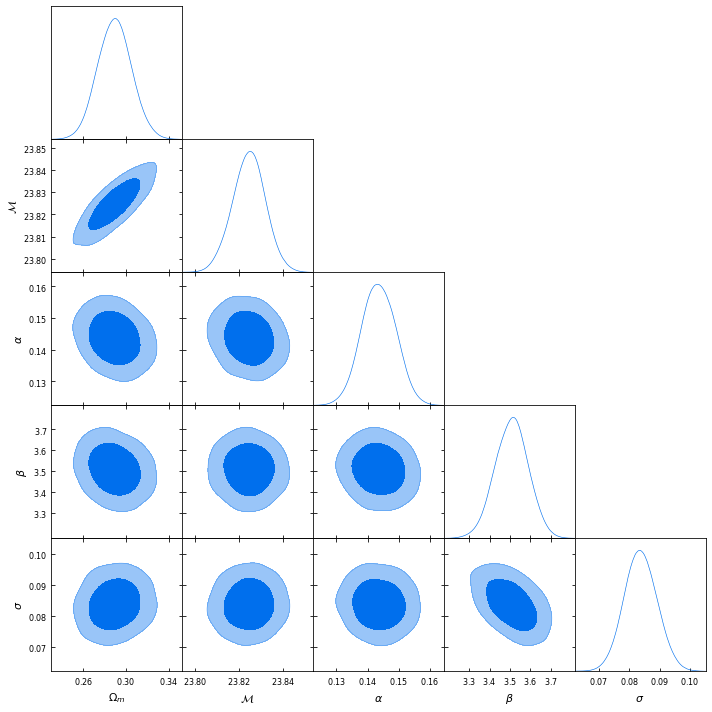

In [22]:
g = plots.get_subplot_plotter()
samples_salt2_bias_cor.updateSettings({'contours': [0.68, 0.95]})
g.settings.num_plot_contours = 2
g.triangle_plot(samples_salt2_bias_cor, filled=True)

## Ajuste SALT2 com gamma

In [23]:
cosmo_salt2.log_probability_salt2_w_gamma([0.3,24.,0.12,3.5,0.1,0.1])

/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


-214.0381019235087

In [24]:
pos = np.array([0.3,24.,0.1,3.5,0.1,0.1])+0.01*np.random.randn(100, 6)
nwalkers, ndim = pos.shape

In [25]:
with Pool() as pool:
    sampler_salt2_gamma = emcee.EnsembleSampler(nwalkers, ndim, cosmo_salt2.log_probability_salt2_w_gamma, pool=pool)
    sampler_salt2_gamma.run_mcmc(pos, 2000, progress=True)

  0%|                                          | 5/2000 [00:00<04:32,  7.32it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
  0%|▏                                         | 7/2000 [00:00<04:29,  7.40it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
  0%|▏                                        | 10/2000 [00:01<04:32,  7.30it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)

#### Chains SALT2 novo

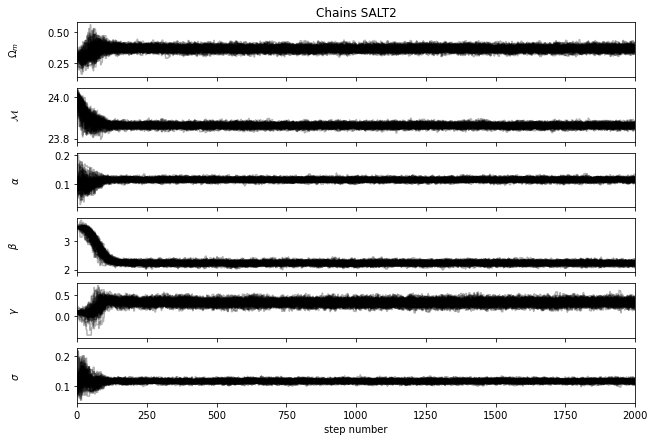

In [26]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples_salt2_gamma = sampler_salt2_gamma.get_chain()
labels = [r"$\Omega_m$",r"$\mathcal{M}$",r"$\alpha$",r"$\beta$",r"$\gamma$",r"$\sigma$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_salt2_gamma[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_salt2_gamma))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    if i==0:
        ax.set_title("Chains SALT2")

    
axes[-1].set_xlabel("step number");

In [27]:
flat_samples_salt2_gamma = sampler_salt2_gamma.get_chain(discard=1000, thin=15, flat=True) # oq esse thin significa?

In [28]:
labels_gdist = [r"\Omega_m",r"\mathcal{M}",r"\alpha",r"\beta",r"\gamma",r"\sigma"]
names_gdist = ["Om","M","a","b","gam","sig"]
samples_salt2_gamma = MCSamples(samples=flat_samples_salt2_gamma, names=names_gdist, labels=labels_gdist)

Removed no burn in


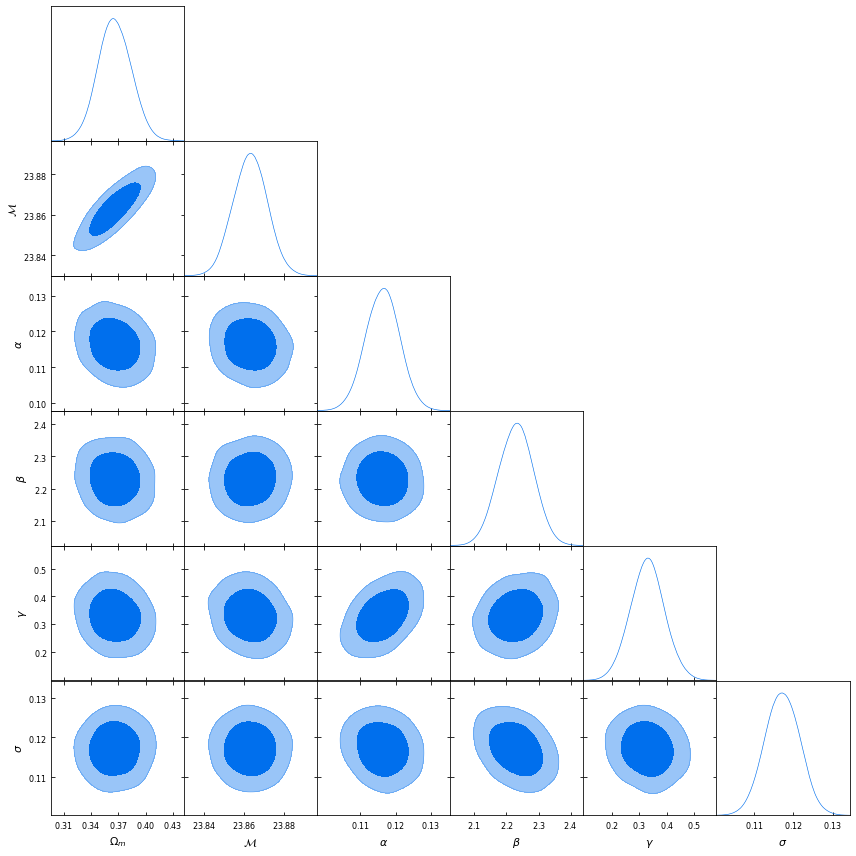

In [29]:
g = plots.get_subplot_plotter()
samples_salt2_gamma.updateSettings({'contours': [0.68, 0.95]})
g.settings.num_plot_contours = 2
g.triangle_plot(samples_salt2_gamma, filled=True)

## Ajuste SALT2 com novos parâmetros

In [30]:
cosmo_salt2.log_probability_salt2_w_new_par([0.3,24.,0.12,3.5,0.1,0.1,0.1,0.2])

-42.09783098205783

In [31]:
pos = np.array([0.3,24.,0.12,3.5,0.1,3.,0.1,0.2])+0.01*np.random.randn(100, 8)
nwalkers, ndim = pos.shape

In [32]:
with Pool() as pool:
    sampler_salt2_new_par = emcee.EnsembleSampler(nwalkers, ndim, cosmo_salt2.log_probability_salt2_w_new_par, pool=pool)
    sampler_salt2_new_par.run_mcmc(pos, 2000, progress=True)

  1%|▎                                        | 15/2000 [00:02<05:22,  6.15it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
  1%|▍                                        | 19/2000 [00:03<05:24,  6.10it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
  1%|▍                                        | 22/2000 [00:03<05:25,  6.08it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
  1%|▍                                        | 24/2000 [00:03<05:24,  6.09it/s]/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWar

#### Chains SALT2 novo

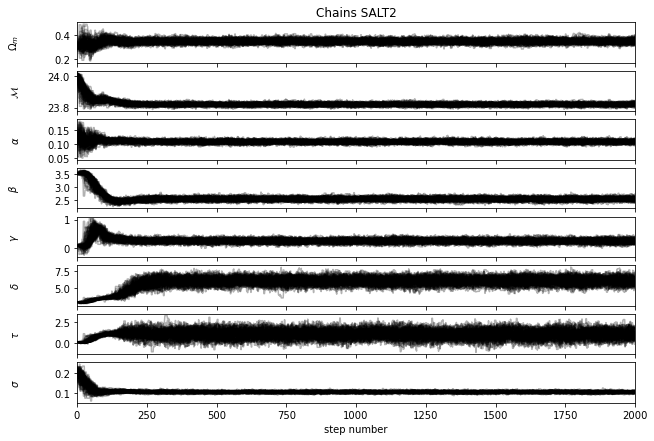

In [33]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples_salt2_new_par = sampler_salt2_new_par.get_chain()
labels = [r"$\Omega_m$",r"$\mathcal{M}$",r"$\alpha$",r"$\beta$",r"$\gamma$",r"$\delta$",r"$\tau$",r"$\sigma$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_salt2_new_par[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_salt2_new_par))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    if i==0:
        ax.set_title("Chains SALT2")

    
axes[-1].set_xlabel("step number");

In [34]:
flat_samples_salt2_new_par = sampler_salt2_new_par.get_chain(discard=1000, thin=15, flat=True) # oq esse thin significa?

In [35]:
labels_gdist = [r"\Omega_m",r"\mathcal{M}",r"\alpha",r"\beta",r"\gamma",r"\delta",r"\tau",r"\sigma"]
names_gdist = ["Om","M","a","b","gam","del","omeg","sig"]
samples_salt2_new_par = MCSamples(samples=flat_samples_salt2_new_par, names=names_gdist, labels=labels_gdist)

Removed no burn in


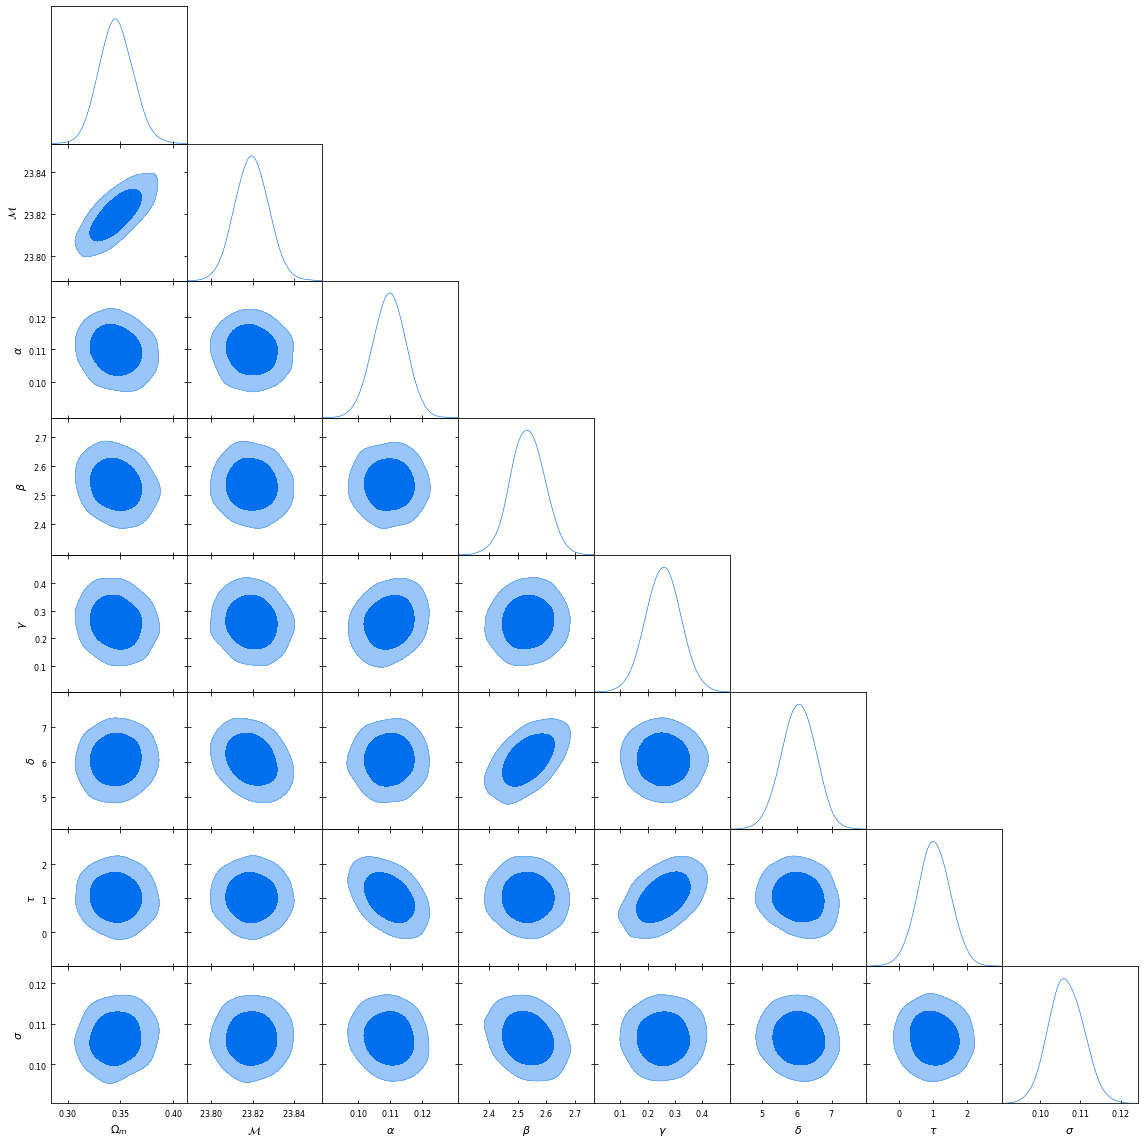

In [36]:
g = plots.get_subplot_plotter()
samples_salt2_new_par.updateSettings({'contours': [0.68, 0.95]})
g.settings.num_plot_contours = 2
g.triangle_plot(samples_salt2_new_par, filled=True)

## Comparações

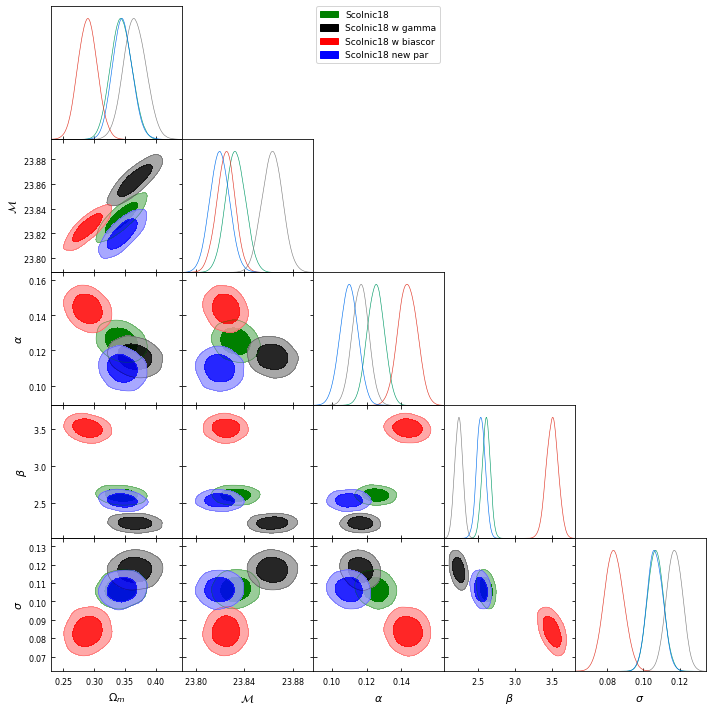

In [37]:
g = plots.get_subplot_plotter()
g.settings.num_plot_contours = 2
g.triangle_plot([samples_salt2,samples_salt2_gamma,samples_salt2_bias_cor,samples_salt2_new_par], legend_labels=['Scolnic18','Scolnic18 w gamma','Scolnic18 w biascor','Scolnic18 new par'],filled=True, colors=["green","black","red","blue"])

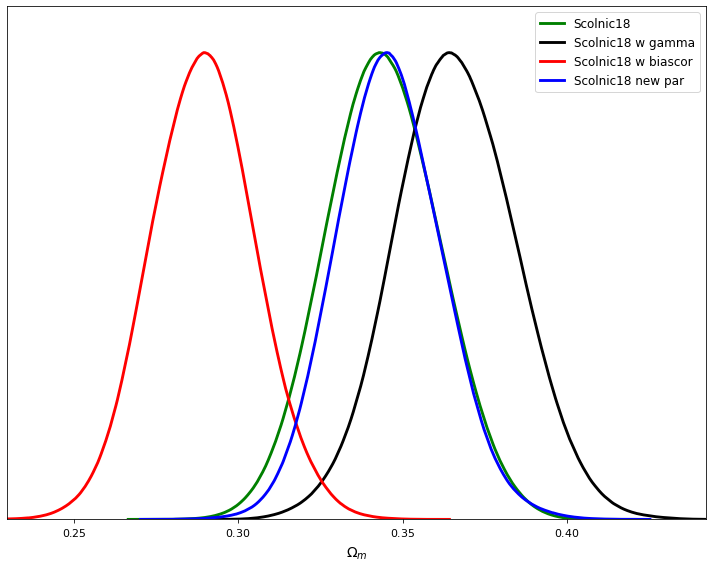

In [38]:
g = plots.get_single_plotter(width_inch=10, ratio=4 / 5.)
g.plot_1d([samples_salt2,samples_salt2_gamma,samples_salt2_bias_cor,samples_salt2_new_par], 'Om', filled=True, colors=["green","black","red","blue"])
g.add_legend(['Scolnic18','Scolnic18 w gamma','Scolnic18 w biascor','Scolnic18 new par']);

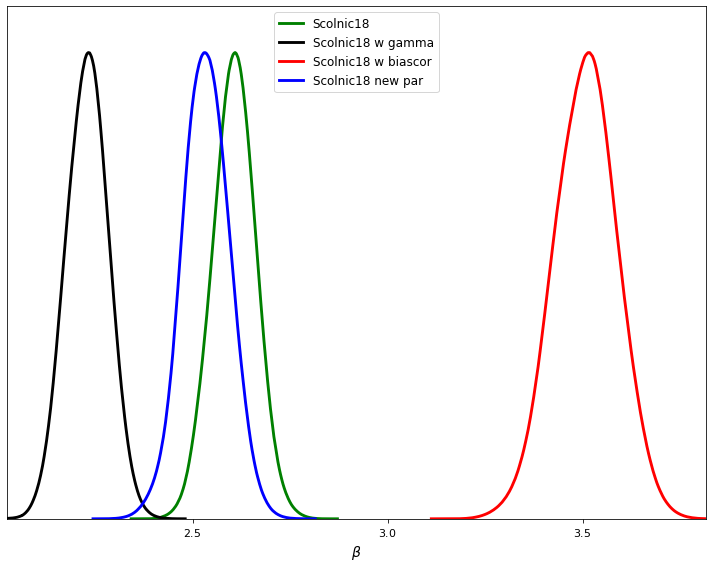

In [39]:
g = plots.get_single_plotter(width_inch=10, ratio=4 / 5.)
g.plot_1d([samples_salt2,samples_salt2_gamma,samples_salt2_bias_cor,samples_salt2_new_par], 'b', filled=True, colors=["green","black","red","blue"])
g.add_legend(['Scolnic18','Scolnic18 w gamma','Scolnic18 w biascor','Scolnic18 new par']);

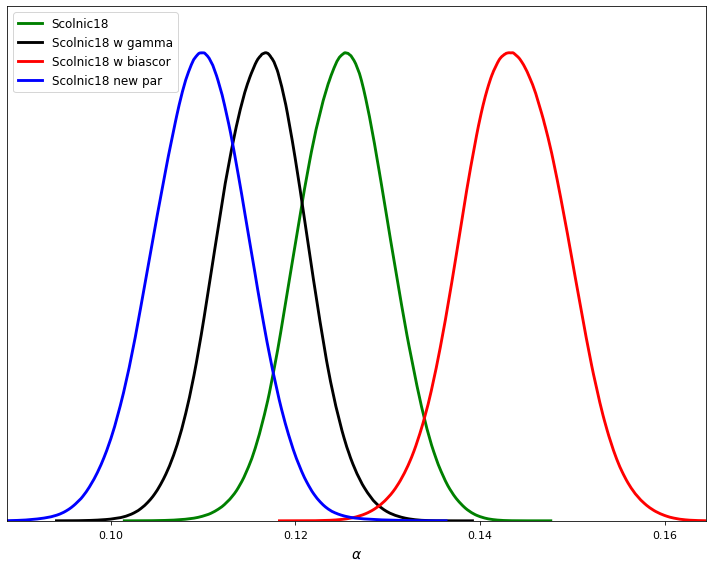

In [40]:
g = plots.get_single_plotter(width_inch=10, ratio=4 / 5.)
g.plot_1d([samples_salt2,samples_salt2_gamma,samples_salt2_bias_cor,samples_salt2_new_par], 'a', filled=True, colors=["green","black","red","blue"])
g.add_legend(['Scolnic18','Scolnic18 w gamma','Scolnic18 w biascor','Scolnic18 new par']);

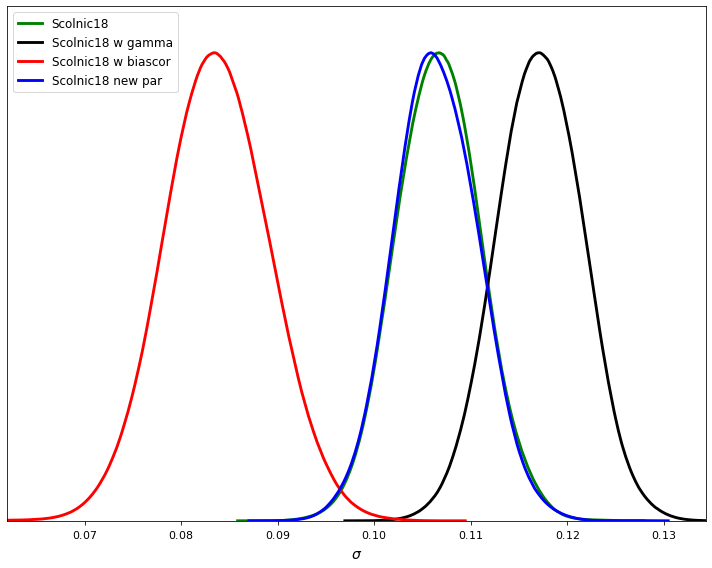

In [41]:
g = plots.get_single_plotter(width_inch=10, ratio=4 / 5.)
g.plot_1d([samples_salt2,samples_salt2_gamma,samples_salt2_bias_cor,samples_salt2_new_par], 'sig', filled=True, colors=["green","black","red","blue"])
g.add_legend(['Scolnic18','Scolnic18 w gamma','Scolnic18 w biascor','Scolnic18 new par']);